In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import pickle

#Simulation Parameters

n = 5 #Number of Agents
t = 100 #Number of timesteps
p1 = 0.1 #probability of the first bandit giving reward +1
p2 = 0.3 #probability of the second bandit giving reward +1
beta = 4*np.ones(n) #agent's inverse temperature
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 100 #number of simulations

In [ ]:
#Functions to simulate
Qval = np.zeros((n,2)) #array to store the Q-values

def softmax(aQ,a_beta): 
    val = 1/(1+np.exp(-a_beta*(aQ[0]-aQ[1]))) #returns the softmax values
    return val,1-val 

def return_action(agent_id,Qval,beta):
    a_beta = beta[agent_id]
    aQ = Qval[agent_id]
    #print(a_beta)
    #print(aQ)
    probs = softmax(aQ,a_beta)
    #print(probs)
    action = np.random.choice([0,1],p = list(probs)) #chooses action based on softmax values
    return action

def bandit_reward(action):
    pss = [p1,p2] #stored in array for convenience
    return np.random.choice([1,-1],p=[pss[action],1-pss[action]]) #return reward from chosen bandit

def calculateUc(R,P,alpha1,alpha2,Qval,n,action,agent_id): #calculate the change to the Qvalues for chosen action
    val1 = 0
    val2 = 0
    #print(R,P)
    for id in R:
        val1 += (1-Qval[agent_id,action])
    val1 = alpha1*val1
    for id in P:
        val2 += (-1-Qval[agent_id,action])
    val2 = alpha2*val2
    return (val1+val2)/n

def calculateUu(R,P,alpha1,alpha2,Qval,n,action,agent_id): #calculate the change to the Qvalues for action not selected
    val1 = 0
    val2 = 0
    #print(R,P)
    for id in R:
        val1 += (1-Qval[agent_id,1-action])
    val1 = alpha2*val1
    for id in P:
        val2 += (-1-Qval[agent_id,1-action])
    val2 = alpha1*val2
    return (val1+val2)/n 

def softmax_mod(dQ,a_beta): 
    val = 1/(1+np.exp(-a_beta*(dQ))) #returns the softmax values
    return val

def multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta):
    net_reward = 0
    for i in range(t):
        Qval2 = np.copy(Qval)
        rewards = []
        actions = []
        b1_w = []
        b2_w = []
        b1_l = []
        b2_l = []
        for agent_id in range(n):
            action = return_action(agent_id,Qval,beta) #find the action and rewards of the agents
            reward = bandit_reward(action)
            actions.append(action)
            rewards.append(reward)
            if action == 0 and reward == -1: #classify the agents according to the action and rewards
                b1_l.append(agent_id)
            elif action == 0 and reward == 1:
                b1_w.append(agent_id)
            elif action == 1 and reward == -1:
                b2_l.append(agent_id)
            elif action==1 and reward == 1:
                b2_w.append(agent_id)
        net_reward+=sum(rewards)/n
        for agent_id in range(n): #update the q-values for the agent
            aic = actions[agent_id]
            if aic == 0: #set the sets of reward or penalty and action chosen or not chosen for particular agent
                Ric = b1_w
                Pic = b1_l
                Riu = b2_w
                Piu = b2_l
            else:
                Ric = b2_w
                Pic = b2_l
                Riu = b1_w
                Piu = b1_l
            Uc = calculateUc(Ric,Pic,alpha1,alpha2,Qval,n,aic,agent_id) #calculate the changes in Q's
            Uu = calculateUu(Riu,Piu,alpha1,alpha2,Qval,n,aic,agent_id)
            Qval2[agent_id,aic]+=Uc #update the Q values
            Qval2[agent_id,1-aic]+=Uu
        Qval = Qval2
    return (Qval[0,1]-Qval[0,0]),softmax_mod(Qval[0,1]-Qval[0,0],beta[0]) #return Q val gap and behaviour profile

def simulateKtimes(K,n,t,alpha1,alpha2,beta): #simulate for K times
    dQ_simuls = []
    for k in range(K):
        Qval = np.zeros((n,2)) #array to store the Q-values
        dQ_simuls.append(list(multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta)))
    return dQ_simuls


## Plot of $\Delta Q$ peaks and mean behaviour profile across various bias strengths for poor conditions 

In [ ]:
#Simulation Parameters 

ns = [2,5] #Number of Agents used from prev simulation
t = 1000 #Number of timesteps
p1 = 0.1 #probability of the first bandit giving reward +1
p2 = 0.3 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 1000 #number of simulations
dqmaxs = []
bpmeans = []
for item in range(len(ns)):
    print(ns[item])
    dq_max = []
    bp_mean = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        dQ = np.array([item[0] for item in x1])
        bP = np.array([item[1] for item in x1])
        kde1 = gaussian_kde(dQ, bw_method=0.4)
        #kde2 = gaussian_kde(bP, bw_method=0.4)
        x_vals1 = np.linspace(min(dQ) - 1, max(dQ) + 1, 1000)
        #x_vals2 = np.linspace(min(bP) - 1, max(bP) + 1, 1000)
        kde1_vals = kde1(x_vals1)
        #kde2_vals = kde2(x_vals2)
        peaks1, _ = find_peaks(kde1_vals)
        #peaks2, _ = find_peaks(kde2_vals)
        dq_max.append([x_vals1[peaks1],kde1(x_vals1[peaks1])])
        bp_mean.append(np.mean(bP))
    dqmaxs.append(dq_max)
    bpmeans.append(bp_mean)

with open('fig3A.pkl', 'wb') as f:
    pickle.dump(dqmaxs, f)

with open('fig3D.pkl', 'wb') as f:
    pickle.dump(bpmeans, f)


2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0


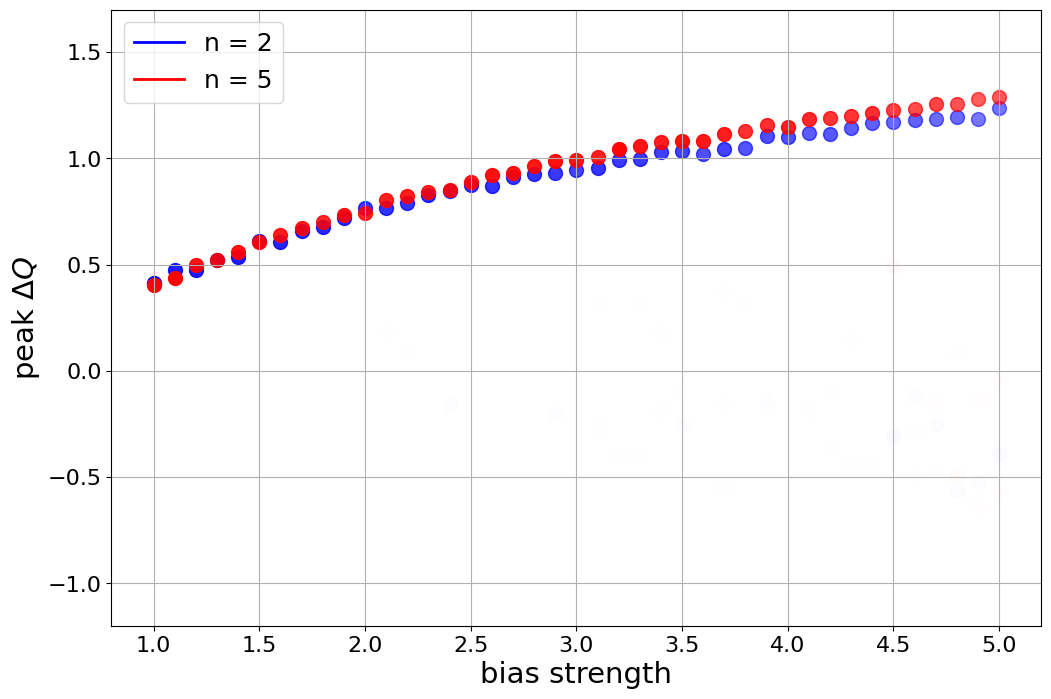

In [108]:
f1 = open('fig3A.pkl',"rb")
f2 = open('fig3D.pkl',"rb")
dqmaxs = pickle.load(f1)
bpmeans = pickle.load(f2)

plt.figure(figsize=(12, 8))
max_alpha = np.max(dqmaxs[0][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[0][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[0][i][1])

for i in range(len(bias)):
    ys = dqmaxs[0][i][0]
    alphas = dqmaxs[0][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'blue')

max_alpha = np.max(dqmaxs[1][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[1][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[1][i][1])

for i in range(len(bias)):
    ys = dqmaxs[1][i][0]
    alphas = dqmaxs[1][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'red')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="blue", lw=2),
               Line2D([0], [0], color="red", lw=2)]

#fig, ax = plt.subplots()
#ax.set_box_aspect(0.8)
#plt.ylabel(r"E - E$_f$ (eV)",fontsize = 20)

plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("bias strength",fontsize = 21)
plt.ylim([-1.2,1.7])
plt.grid()
plt.ylabel(r"peak $\Delta Q$",fontsize = 21)
plt.savefig("Fig3A.jpg",dpi = 500)


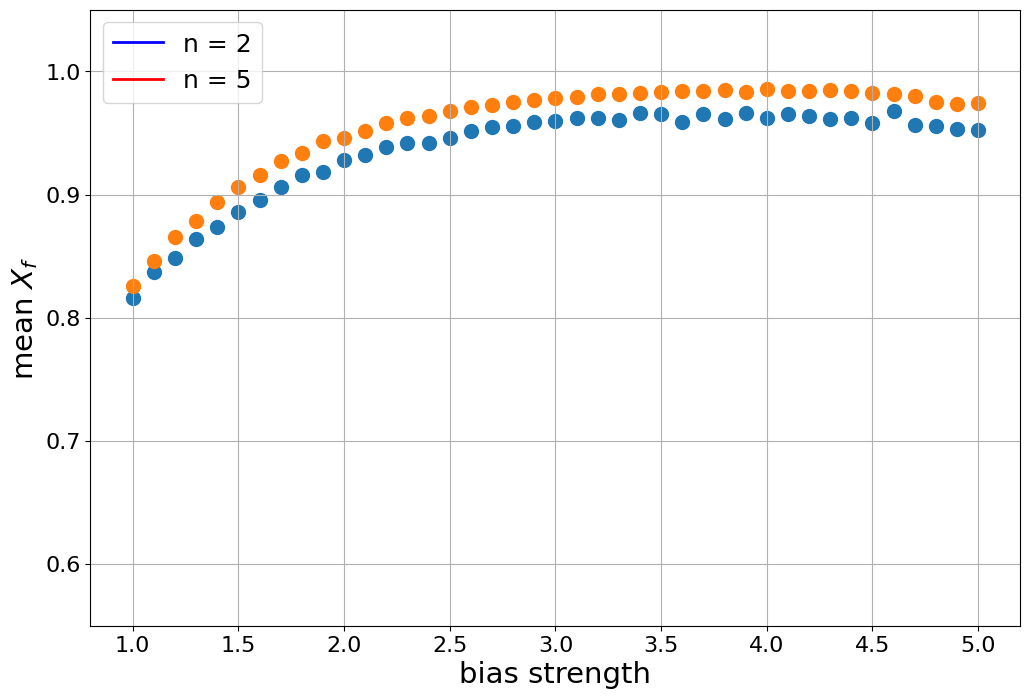

In [99]:
plt.figure(figsize=(12, 8))
plt.scatter(bias,bpmeans[0],s=100,label = "n = 2")
plt.scatter(bias,bpmeans[1],s=100,label = "n = 5")
plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("bias strength",fontsize = 21)
plt.ylabel(r"mean $X_f$",fontsize = 21)
plt.ylim([0.55,1.05])
plt.grid()
plt.savefig("Fig3D.jpg",dpi = 500)

## Plot of $\Delta Q$ peaks and mean behaviour profile across various bias strengths for moderate conditions 

In [ ]:
#Simulation Parameters 

ns = [2,5] #Number of Agents used from prev simulation
t = 1000 #Number of timesteps
p1 = 0.4 #probability of the first bandit giving reward +1
p2 = 0.6 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
#alpha1 = 0.15 #confirmatory learning rate
#alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 1000 #number of simulations
dqmaxs = []
bpmeans = []
for item in range(len(ns)):
    print(ns[item])
    dq_max = []
    bp_mean = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        dQ = np.array([item[0] for item in x1])
        bP = np.array([item[1] for item in x1])
        kde1 = gaussian_kde(dQ, bw_method=0.4)
        #kde2 = gaussian_kde(bP, bw_method=0.4)
        x_vals1 = np.linspace(min(dQ) - 1, max(dQ) + 1, 1000)
        #x_vals2 = np.linspace(min(bP) - 1, max(bP) + 1, 1000)
        kde1_vals = kde1(x_vals1)
        #kde2_vals = kde2(x_vals2)
        peaks1, _ = find_peaks(kde1_vals)
        #peaks2, _ = find_peaks(kde2_vals)
        dq_max.append([x_vals1[peaks1],kde1(x_vals1[peaks1])])
        bp_mean.append(np.mean(bP))
    dqmaxs.append(dq_max)
    bpmeans.append(bp_mean)
    
with open('fig3B.pkl', 'wb') as f:
    pickle.dump(dqmaxs, f)

with open('fig3E.pkl', 'wb') as f:
    pickle.dump(bpmeans, f)



2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0


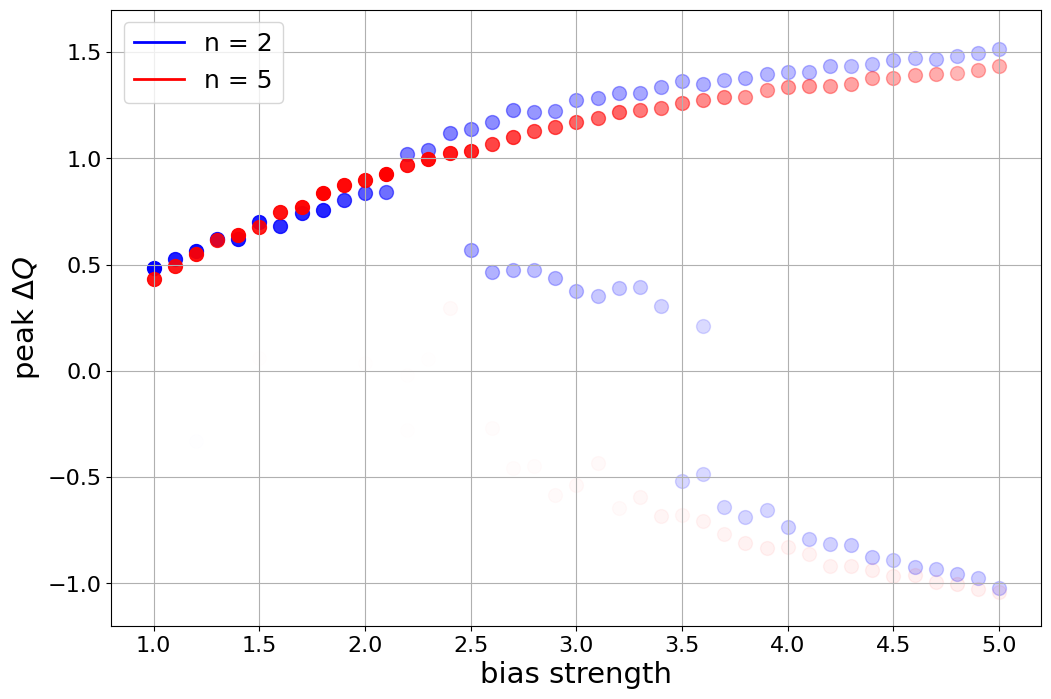

In [105]:
f1 = open('fig3B.pkl',"rb")
f2 = open('fig3E.pkl',"rb")
dqmaxs = pickle.load(f1)
bpmeans = pickle.load(f2)

plt.figure(figsize=(12, 8))
max_alpha = np.max(dqmaxs[0][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[0][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[0][i][1])

for i in range(len(bias)):
    ys = dqmaxs[0][i][0]
    alphas = dqmaxs[0][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'blue')

max_alpha = np.max(dqmaxs[1][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[1][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[1][i][1])

for i in range(len(bias)):
    ys = dqmaxs[1][i][0]
    alphas = dqmaxs[1][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'red')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="blue", lw=2),
               Line2D([0], [0], color="red", lw=2)]

#fig, ax = plt.subplots()
#ax.set_box_aspect(0.8)
#plt.ylabel(r"E - E$_f$ (eV)",fontsize = 20)

plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([-1.2,1.7])
plt.xlabel("bias strength",fontsize = 21)
plt.ylabel(r"peak $\Delta Q$",fontsize = 21)
plt.grid()
plt.savefig("Fig3B.jpg",dpi = 500)


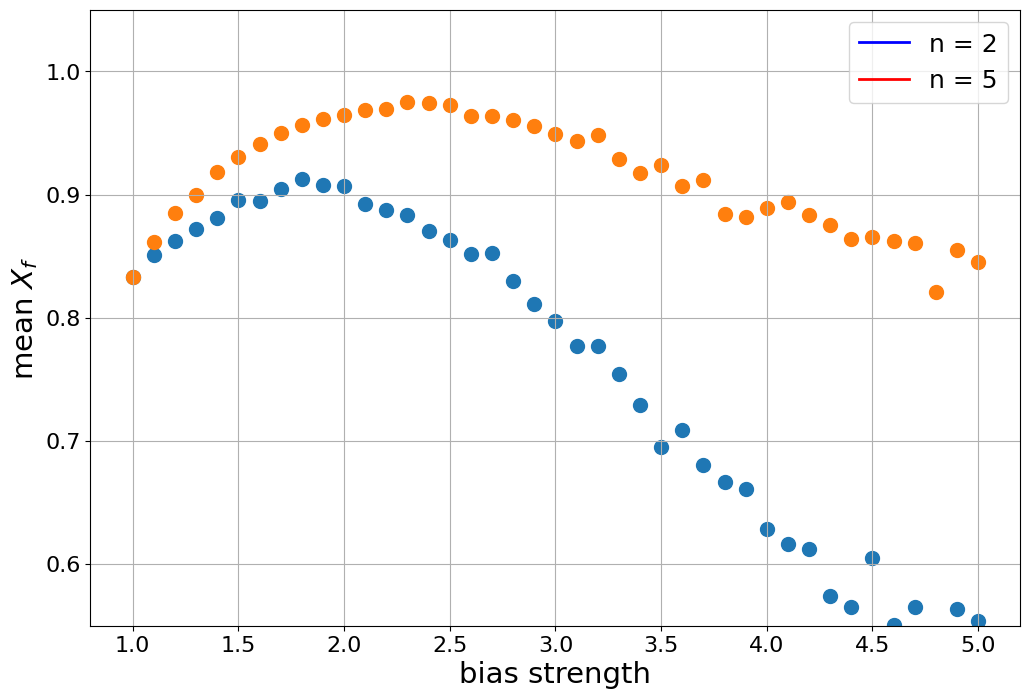

In [106]:
plt.figure(figsize=(12, 8))
plt.scatter(bias,bpmeans[0],s=100,label = "n = 2")
plt.scatter(bias,bpmeans[1],s=100,label = "n = 5")
plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("bias strength",fontsize = 21)
plt.ylabel(r"mean $X_f$",fontsize = 21)
plt.ylim([0.55,1.05])
plt.grid()
plt.savefig("Fig3E.jpg",dpi = 500)

## Plot of $\Delta Q$ peaks and mean behaviour profile across various bias strengths for rich conditions 

In [ ]:
#Simulation Parameters 

ns = [2,5] #Number of Agents used from prev simulation
t = 1000 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
#alpha1 = 0.15 #confirmatory learning rate
#alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 1000 #number of simulations
dqmaxs = []
bpmeans = []
for item in range(len(ns)):
    print(ns[item])
    dq_max = []
    bp_mean = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        dQ = np.array([item[0] for item in x1])
        bP = np.array([item[1] for item in x1])
        kde1 = gaussian_kde(dQ, bw_method=0.4)
        #kde2 = gaussian_kde(bP, bw_method=0.4)
        x_vals1 = np.linspace(min(dQ) - 1, max(dQ) + 1, 1000)
        #x_vals2 = np.linspace(min(bP) - 1, max(bP) + 1, 1000)
        kde1_vals = kde1(x_vals1)
        #kde2_vals = kde2(x_vals2)
        peaks1, _ = find_peaks(kde1_vals)
        #peaks2, _ = find_peaks(kde2_vals)
        dq_max.append([x_vals1[peaks1],kde1(x_vals1[peaks1])])
        bp_mean.append(np.mean(bP))
    dqmaxs.append(dq_max)
    bpmeans.append(bp_mean)
    
with open('fig3C.pkl', 'wb') as f:
    pickle.dump(dqmaxs, f)

with open('fig3F.pkl', 'wb') as f:
    pickle.dump(bpmeans, f)



2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0


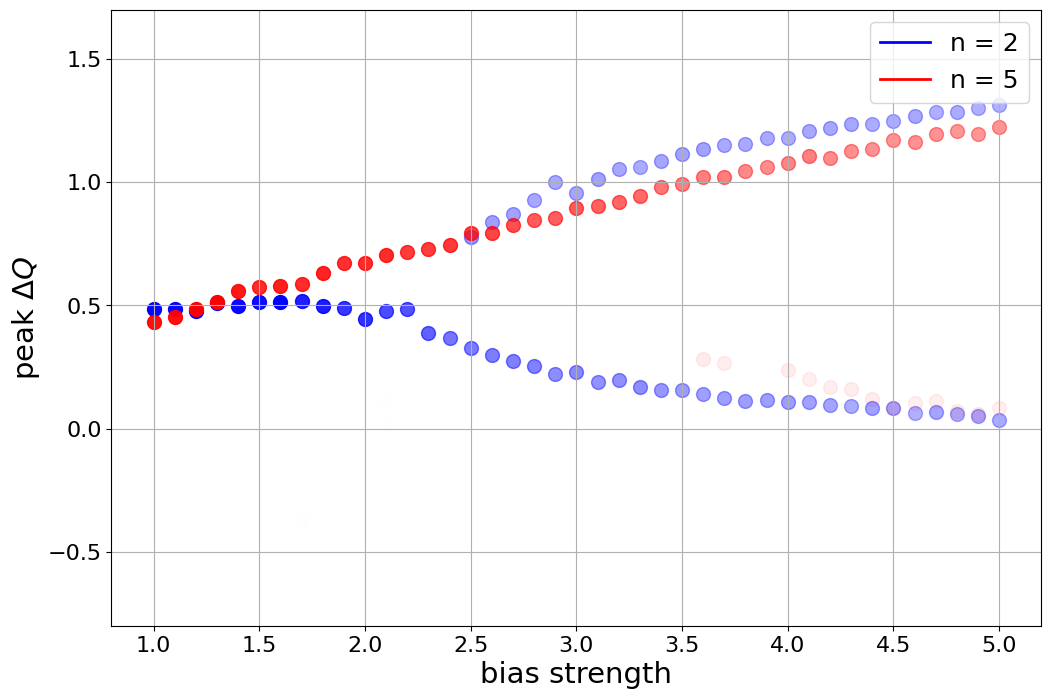

In [95]:
f1 = open('fig3C.pkl',"rb")
f2 = open('fig3F.pkl',"rb")
dqmaxs = pickle.load(f1)
bpmeans = pickle.load(f2)

plt.figure(figsize=(12, 8))
max_alpha = np.max(dqmaxs[0][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[0][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[0][i][1])

for i in range(len(bias)):
    ys = dqmaxs[0][i][0]
    alphas = dqmaxs[0][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'blue')

max_alpha = np.max(dqmaxs[1][0][1])
for i in range(len(bias)):
    if np.max(dqmaxs[1][i][1])>max_alpha:
        max_alpha = np.max(dqmaxs[1][i][1])

for i in range(len(bias)):
    ys = dqmaxs[1][i][0]
    alphas = dqmaxs[1][i][1]/max_alpha
    for j in range(len(ys)):
        plt.scatter(bias[i],ys[j],s=100,alpha = alphas[j],color = 'red')

from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color="blue", lw=2),
               Line2D([0], [0], color="red", lw=2)]

#fig, ax = plt.subplots()
#ax.set_box_aspect(0.8)
#plt.ylabel(r"E - E$_f$ (eV)",fontsize = 20)

plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim([-0.8,1.7])
plt.grid()
plt.xlabel("bias strength",fontsize = 21)
plt.ylabel(r"peak $\Delta Q$",fontsize = 21)
plt.savefig("Fig3C.jpg",dpi = 500)


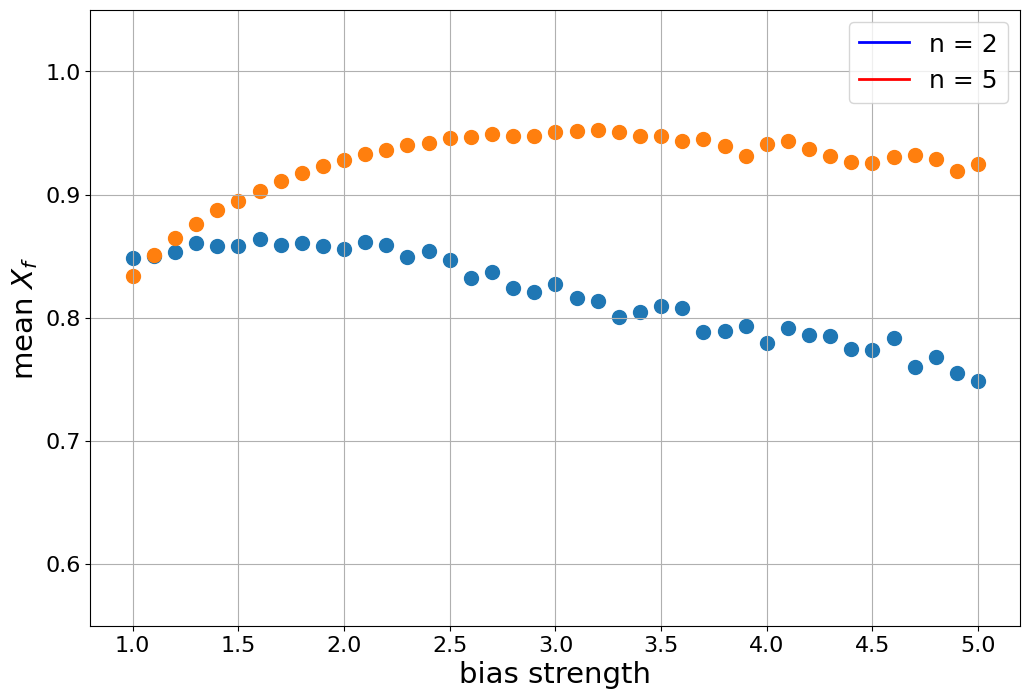

In [96]:
plt.figure(figsize=(12, 8))
plt.scatter(bias,bpmeans[0],s=100,label = "n = 2")
plt.scatter(bias,bpmeans[1],s=100,label = "n = 5")
plt.legend(custom_lines, ['n = 2', 'n = 5'],fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel("bias strength",fontsize = 21)
plt.ylabel(r"mean $X_f$",fontsize = 21)
plt.ylim([0.55,1.05])
plt.grid()
plt.savefig("Fig3F.jpg",dpi = 500)

In [ ]:
def multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta):
    net_reward = 0
    for i in range(t):
        Qval2 = np.copy(Qval)
        rewards = []
        actions = []
        b1_w = []
        b2_w = []
        b1_l = []
        b2_l = []
        for agent_id in range(n):
            action = return_action(agent_id,Qval,beta) #find the action and rewards of the agents
            reward = bandit_reward(action)
            actions.append(action)
            rewards.append(reward)
            if action == 0 and reward == -1: #classify the agents according to the action and rewards
                b1_l.append(agent_id)
            elif action == 0 and reward == 1:
                b1_w.append(agent_id)
            elif action == 1 and reward == -1:
                b2_l.append(agent_id)
            elif action==1 and reward == 1:
                b2_w.append(agent_id)
        if i>=t/2:
            net_reward+=sum(rewards)/n
        for agent_id in range(n): #update the q-values for the agent
            aic = actions[agent_id]
            if aic == 0: #set the sets of reward or penalty and action chosen or not chosen for particular agent
                Ric = b1_w
                Pic = b1_l
                Riu = b2_w
                Piu = b2_l
            else:
                Ric = b2_w
                Pic = b2_l
                Riu = b1_w
                Piu = b1_l
            Uc = calculateUc(Ric,Pic,alpha1,alpha2,Qval,n,aic,agent_id) #calculate the changes in Q's
            Uu = calculateUu(Riu,Piu,alpha1,alpha2,Qval,n,aic,agent_id)
            Qval2[agent_id,aic]+=Uc #update the Q values
            Qval2[agent_id,1-aic]+=Uu
        Qval = Qval2
    return 2*net_reward/t #return average reward

def simulateKtimes(K,n,t,alpha1,alpha2,beta): #simulate for K times
    rds = []
    for k in range(K):
        Qval = np.zeros((n,2)) #array to store the Q-values
        rds.append(multi_agent_two_armed_bandit(n,t,Qval,alpha1,alpha2,beta))
    return sum(rds)/K

## Performance improvement plot for poor environment

In [ ]:
#Simulation Parameters 

ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.1 #probability of the first bandit giving reward +1
p2 = 0.3 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations
rdmean = []
for item in range(len(ns)):
    print(ns[item])
    rd_means = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        rd_means.append(x1)
    rdmean.append(rd_means)

rdmean = np.array(rdmean)+0.6

with open('fig3G.pkl', 'wb') as f:
    pickle.dump(rdmean, f)




1
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
3
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
4
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
6
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
7
1.

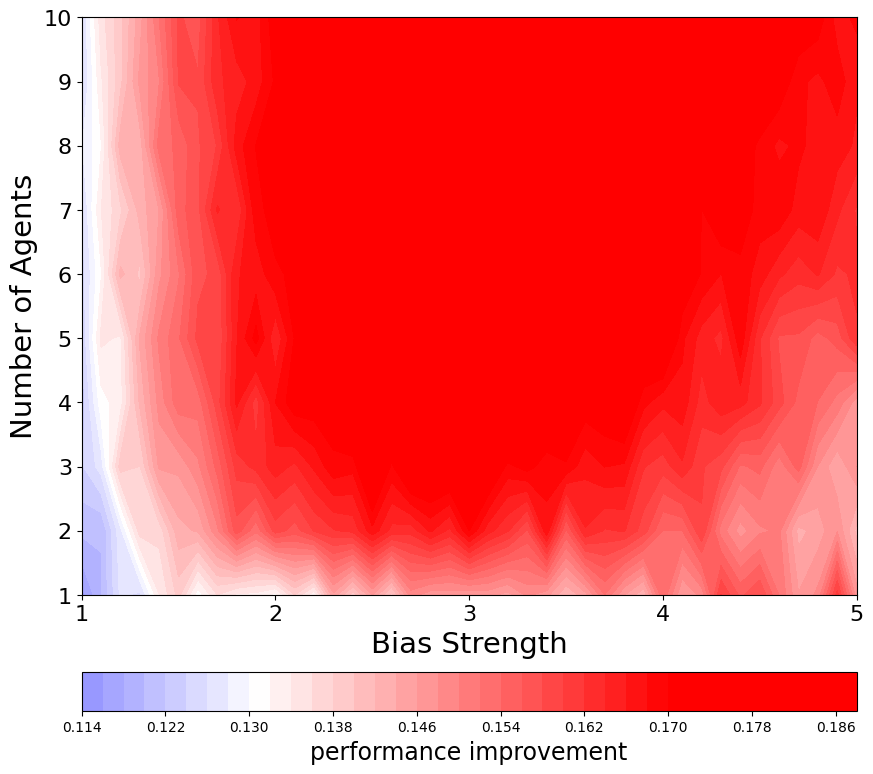

In [158]:
f = open('fig3G.pkl',"rb")
rdmean = pickle.load(f)
x = bias
y = ns
x,y = np.meshgrid(x,y)
# Create the plot
plt.figure(figsize=(10, 10))
contour = plt.contourf(x, y, rdmean, levels=40, cmap='bwr')
x_ticks = bias[::10]
y_ticks = ns
# Set custom ticks
plt.xticks(x_ticks,fontsize = 16)
plt.yticks(ns,fontsize = 16)
plt.clim(vmin = 0.09150,vmax = 0.17)

# Add labels and a color bar for context
plt.xlabel("Bias Strength",fontsize = 21)
plt.ylabel("Number of Agents",fontsize = 21)
cbar = plt.colorbar(orientation="horizontal", pad=0.1)
cbar.set_label("performance improvement", fontsize=17) 
plt.savefig("Fig3G.jpg",dpi = 500)

## Performance improvement plot for moderate environment

In [ ]:
#Simulation Parameters 

ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.4 #probability of the first bandit giving reward +1
p2 = 0.6 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations
rdmean = []
for item in range(len(ns)):
    print(ns[item])
    rd_means = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        rd_means.append(x1)
    rdmean.append(rd_means)

rdmean = np.array(rdmean)+0.6

with open('fig3H.pkl', 'wb') as f:
    pickle.dump(rdmean, f)
    

1
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
3
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
4
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
6
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
7
1.

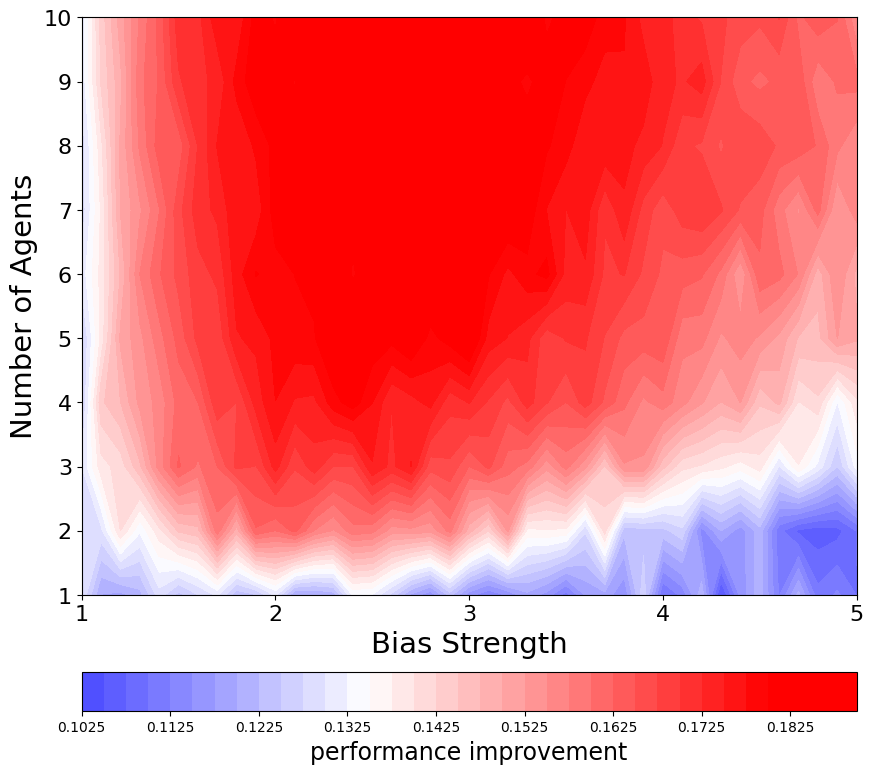

In [7]:
f = open('fig3H.pkl',"rb")
rdmean = pickle.load(f)-0.6
ns = list(range(1,11)) 
bias = np.arange(1,5.1,0.1)
x = bias
y = ns
x,y = np.meshgrid(x,y)
# Create the plot
plt.figure(figsize=(10, 10))
contour = plt.contourf(x, y, rdmean, levels=40, cmap='bwr')
x_ticks = bias[::10]
y_ticks = ns
# Set custom ticks
plt.xticks(x_ticks,fontsize = 16)
plt.yticks(ns,fontsize = 16)
plt.clim(vmin = 0.08940,vmax = 0.18)

# Add labels and a color bar for context
plt.xlabel("Bias Strength",fontsize = 21)
plt.ylabel("Number of Agents",fontsize = 21)
cbar = plt.colorbar(orientation="horizontal", pad=0.1)
cbar.set_label("performance improvement", fontsize=17) 
plt.savefig("Fig3H.jpg",dpi = 500)

## Performance improvement plot for rich environment

In [ ]:
#Simulation Parameters 
ns = list(range(1,11)) #Number of Agents used from prev simulation
t = 200 #Number of timesteps
p1 = 0.7 #probability of the first bandit giving reward +1
p2 = 0.9 #probability of the second bandit giving reward +1
betas = [4*np.ones(n) for n in ns] #agent's inverse temperature
bias = np.arange(1,5.1,0.1)
alpha1 = 0.15 #confirmatory learning rate
alpha2 = 0.05 #anti-conrfirmatory learning rate
K = 500 #number of simulations
rdmean = []
for item in range(len(ns)):
    print(ns[item])
    rd_means = []
    for b in bias:
        print(round(b,2))
        alpha1 = 0.2*b/(b+1)
        alpha2 = 0.2/(b+1)
        beta = betas[item]
        x1 = simulateKtimes(K,ns[item],t,alpha1,alpha2,beta)
        rd_means.append(x1)
    rdmean.append(rd_means)

rdmean = np.array(rdmean)-0.6

with open('fig3I.pkl', 'wb') as f:
    pickle.dump(rdmean, f)
    

1
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
2
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
3
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
4
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
6
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
7
1.

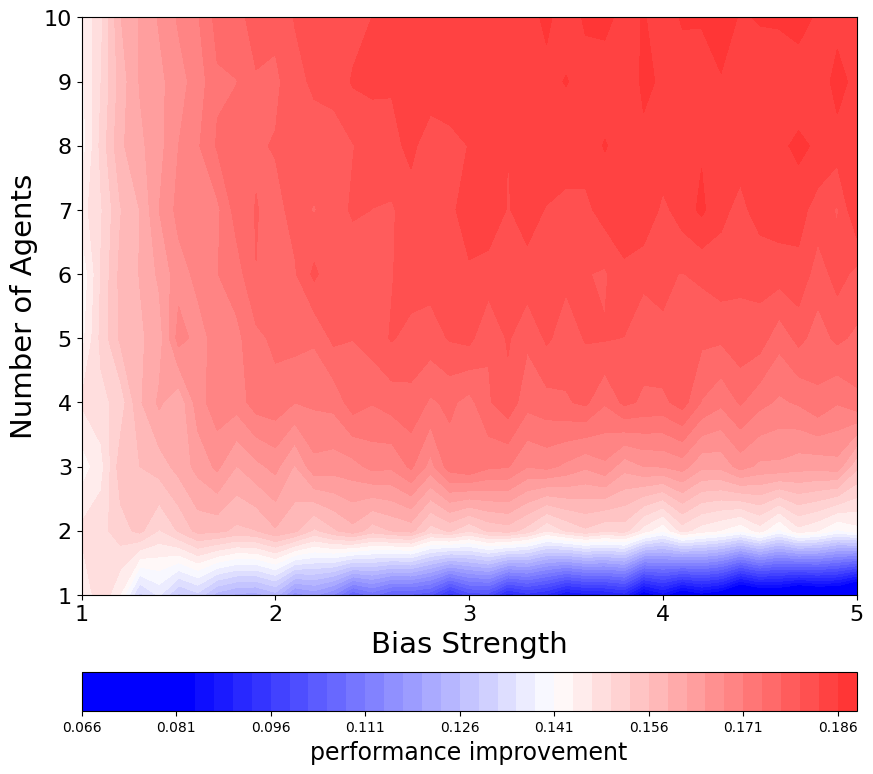

In [19]:
f = open('fig3I.pkl',"rb")
rdmean = pickle.load(f)
x = bias
y = ns
x,y = np.meshgrid(x,y)
# Create the plot
plt.figure(figsize=(10, 10))
contour = plt.contourf(x, y, rdmean, levels=40, cmap='bwr')
x_ticks = bias[::10]
y_ticks = ns
# Set custom ticks
plt.xticks(x_ticks,fontsize = 16)
plt.yticks(ns,fontsize = 16)
plt.clim(vmin = 0.08220,vmax = 0.20)

# Add labels and a color bar for context
plt.xlabel("Bias Strength",fontsize = 21)
plt.ylabel("Number of Agents",fontsize = 21)
cbar = plt.colorbar(orientation="horizontal", pad=0.1)
cbar.set_label("performance improvement", fontsize=17) 
plt.savefig("Fig3I.jpg",dpi = 500)